# Point Cloud Classification with PointNet

In [1]:
#pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [ ]:
# Use hardware accelerator for training
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Download the Dataset

In [3]:
#Do not run if the data files are already downloaded
# #DATA_DIR = tf.keras.utils.get_file(
#     "modelnet.zip",
#     "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
#     extract=True,
# )
# DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 [==============================] - 100s 0us/step


In [10]:
DATA_DIR = "C:/Own use/3D_image_Data/Modelnet40_Shapenet/ModelNet40_Shapenet"

## Visualize a Mesh from the Dataset

In [ ]:
# DATA_DIR = 'C:/Users/iskso/OneDrive - OsloMet/ACIT4030_GroupWork_3D-Image/04.Dataset/Modelnet40_Shapenet/ModelNet40_Shapenet/'
# mesh = trimesh.load(os.path.join(DATA_DIR, "curtain/train/curtain_0094.off"))
# mesh.show()

## Sample a Mesh and Show Result

In [ ]:
# points = mesh.sample(2048)

# fig = plt.figure(figsize=(16, 12))
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(points[:, 0], points[:, 1], points[:, 2])
# ax.set_axis_off()
# plt.show()

## Function to Parse Data
- Each mesh is loaded and sampled into a point cloud and is returned as a numpy array

In [11]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = os.path.basename(folder)
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

## Parse the Dataset and Process each Class

In [12]:
NUM_POINTS = 2048
NUM_CLASSES = 49
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: airplane
processing class: Bag
processing class: bathtub
processing class: bed
processing class: bench
processing class: bookshelf
processing class: bottle
processing class: bowl
processing class: Cap
processing class: car
processing class: chair
processing class: cone
processing class: cup
processing class: curtain


c:\Users\zihad\AppData\Local\Programs\Python\Python310\lib\site-packages\trimesh\grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


processing class: desk
processing class: door
processing class: dresser
processing class: Earphone
processing class: flower_pot
processing class: glass_box
processing class: guitar
processing class: keyboard
processing class: Knife
processing class: lamp
processing class: laptop
processing class: mantel
processing class: monitor
processing class: Motorbike
processing class: Mug
processing class: night_stand
processing class: person
processing class: piano
processing class: Pistol
processing class: plant
processing class: radio
processing class: range_hood
processing class: Rocket
processing class: sink
processing class: Skateboard
processing class: sofa
processing class: stairs
processing class: stool
processing class: table
processing class: tent
processing class: toilet
processing class: tv_stand
processing class: vase
processing class: wardrobe
processing class: xbox


In [13]:
from collections import Counter

# Print class labels and the number of samples per class
class_counts = Counter(train_labels)
for class_id, count in class_counts.items():
    print(f"Class {class_id} ({CLASS_MAP[class_id]}): {count} train samples")
print("\n")
class_counts = Counter(test_labels)
for class_id, count in class_counts.items():
    print(f"Class {class_id} ({CLASS_MAP[class_id]}): {count} test samples")

Class 0 (airplane): 826 train samples
Class 1 (Bag): 40 train samples
Class 2 (bathtub): 106 train samples
Class 3 (bed): 515 train samples
Class 4 (bench): 173 train samples
Class 5 (bookshelf): 572 train samples
Class 6 (bottle): 335 train samples
Class 7 (bowl): 64 train samples
Class 8 (Cap): 30 train samples
Class 9 (car): 397 train samples
Class 10 (chair): 1089 train samples
Class 11 (cone): 167 train samples
Class 12 (cup): 79 train samples
Class 13 (curtain): 137 train samples
Class 14 (desk): 200 train samples
Class 15 (door): 109 train samples
Class 16 (dresser): 200 train samples
Class 17 (Earphone): 40 train samples
Class 18 (flower_pot): 149 train samples
Class 19 (glass_box): 171 train samples
Class 20 (guitar): 355 train samples
Class 21 (keyboard): 145 train samples
Class 22 (Knife): 200 train samples
Class 23 (lamp): 324 train samples
Class 24 (laptop): 349 train samples
Class 25 (mantel): 284 train samples
Class 26 (monitor): 465 train samples
Class 27 (Motorbike): 1

## Augmentation for Train Dataset

In [14]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## Save and Load train/test variables

In [15]:
#Save train/test variables
# Specify a directory path to save the files
save_directory = "C:/Users/zihad/OneDrive - OsloMet/ACIT4030_GroupWork_3D-Image/10.Train-Test_Variables/03.ModelNet40_ShapeNet/02.Epoch_20/"

# Save train and test datasets to the specified directory
np.save(save_directory + 'train_points.npy', train_points)
np.save(save_directory + 'test_points.npy', test_points)
np.save(save_directory + 'train_labels.npy', train_labels)
np.save(save_directory + 'test_labels.npy', test_labels)
np.save(save_directory + 'class_map.npy', CLASS_MAP)

In [ ]:
# # Load train/test variables

# NUM_POINTS = 2048
# NUM_CLASSES = 40
# BATCH_SIZE = 32

# # Specify the directory path where the saved files are located
# load_directory = "C:/Users/duytr/OneDrive - OsloMet/ACIT4030_GroupWork_3D-Image/10.Train-Test_Variables/02.ModelNet40/01.Epoch_1/"

# # Load the saved datasets
# train_points = np.load(load_directory + 'train_points.npy')
# test_points = np.load(load_directory + 'test_points.npy')
# train_labels = np.load(load_directory + 'train_labels.npy')
# test_labels = np.load(load_directory + 'test_labels.npy')
# CLASS_MAP = np.load(load_directory + 'class_map.npy', allow_pickle=True).item()


# def augment(points, label):
#     # jitter points
#     points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
#     # shuffle points
#     points = tf.random.shuffle(points)
#     return points, label

# #Convert train/test_points to train/test_dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

# train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## Functions to Build the Model

In [16]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [17]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    def get_config(self):
        return {'num_features': self.num_features, 'l2reg': self.l2reg}

# Add this decorator to ensure proper serialization
@keras.utils.register_keras_serializable(package='Custom', name='OrthogonalRegularizer')
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    def get_config(self):
        return {'num_features': self.num_features, 'l2reg': self.l2reg}

## Function to create T-net Layers

In [18]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

## Create the Convolutional Neural Network

In [19]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2048, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2048, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2048, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 2048, 32)             0         ['batch_normalization[0

## Compile and Train the Model

In [20]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
376/376 [==============================] - 529s 1s/step - loss: 4.8940 - sparse_categorical_accuracy: 0.1037 - val_loss: 213858213380292083712.0000 - val_sparse_categorical_accuracy: 0.1043
Epoch 2/20
376/376 [==============================] - 520s 1s/step - loss: 4.4751 - sparse_categorical_accuracy: 0.1426 - val_loss: 1655830014253334528.0000 - val_sparse_categorical_accuracy: 0.1127
Epoch 3/20
376/376 [==============================] - 492s 1s/step - loss: 4.2249 - sparse_categorical_accuracy: 0.1647 - val_loss: 179234064456044511232.0000 - val_sparse_categorical_accuracy: 0.1068
Epoch 4/20
376/376 [==============================] - 498s 1s/step - loss: 4.1035 - sparse_categorical_accuracy: 0.1722 - val_loss: 11328190121301346615296.0000 - val_sparse_categorical_accuracy: 0.1302
Epoch 5/20
376/376 [==============================] - 488s 1s/step - loss: 4.0954 - sparse_categorical_accuracy: 0.1840 - val_loss: 34.3547 - val_sparse_categorical_accuracy: 0.0462
Epoch 6/20
376

## Save and Load Trained Model

In [21]:
#Save the trained model
output_dir = 'C:/Users/zihad/OneDrive - OsloMet/ACIT4030_GroupWork_3D-Image/09.Trained_Models/03.ModelNet40_ShapeNet/02.Epoch_20'
# Save the trained model in the output directory

model.save(os.path.join(output_dir, "cnn_model_d111123_epoch20.keras"))

In [27]:
print(type(history))

<class 'keras.src.callbacks.History'>


In [33]:
# # Load the trained model with a custom object scope
# output_dir = 'C:/Users/duytran/OneDrive - OsloMet/ACIT4030_GroupWork_3D-Image/09.Trained_Models/03.ModelNet40_ShapeNet/01.Epoch_10'
# model_path = os.path.join(output_dir, "cnn_model_d101123_epoch1.keras")
# model = keras.models.load_model(model_path)

## Visualize The Predictions

1/1 [==============================] - 0s 66ms/step


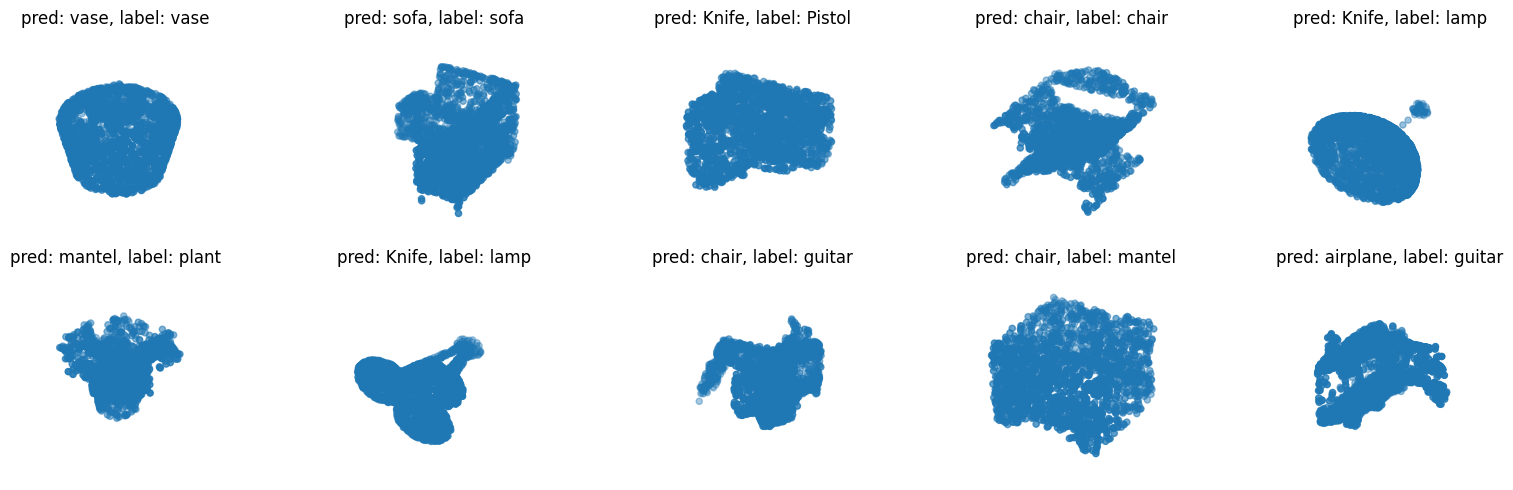

In [33]:
data = test_dataset.take(11)

points, labels = list(data)[0]
points = points[:10, ...]
labels = labels[:10, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(16, 12))
for i in range(10):
    ax = fig.add_subplot(5, 5, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
save_filename = 'Train-Test_Prediction_Epoch_20(4).png'
save_path = os.path.join(output_dir, save_filename)
dpi=600
plt.savefig(save_path, dpi=dpi)
plt.tight_layout(pad=0.5)
plt.show()

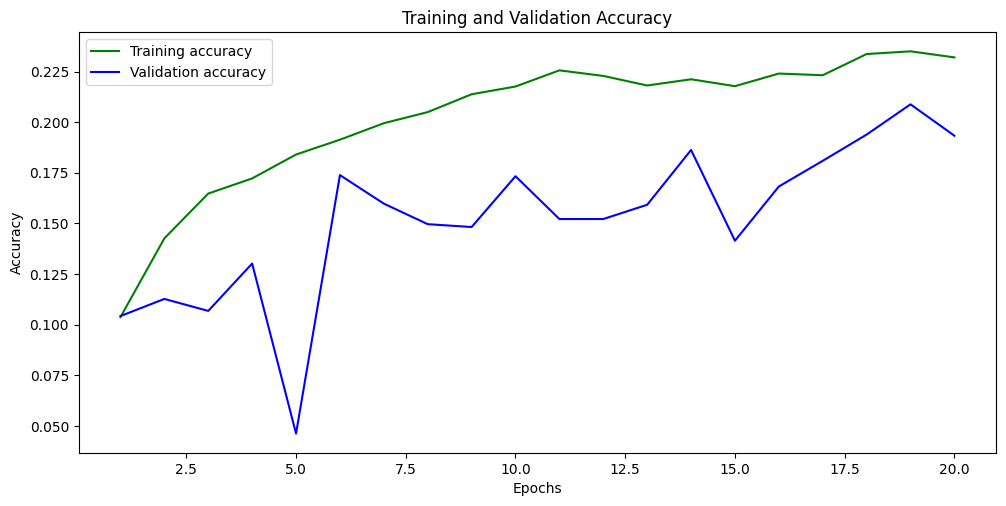

In [26]:
#Accuracy Chart
#########################
# Assuming you have the history object from model training
# history = model.fit(...) or history = load_model('your_model.h5')

plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 1, 1)
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout(pad=0.5)
save_filename = 'Train-Validation_Accuracy_Epoch_20.png'
save_path = os.path.join(output_dir, save_filename)
dpi=600
plt.savefig(save_path, dpi=dpi)
plt.show()

In [27]:
# Assuming you have already trained your model and have the 'history' object
if 'sparse_categorical_accuracy' in history.history and 'val_sparse_categorical_accuracy' in history.history:
    train_acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    
    # Check if data is present
    print(history.history.keys())  # To see all available metrics
    print(train_acc)
    print(val_acc)
    print(history.history['loss'])
    print(history.history['val_loss'])

    # Rest of your plotting code here
else:
    print("Accuracy data not found in history. Check your metric names or training process.")


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])
[0.10372340679168701, 0.14261968433856964, 0.16472738981246948, 0.17220744490623474, 0.18400931358337402, 0.19132313132286072, 0.19946809113025665, 0.20495346188545227, 0.2137632966041565, 0.2175864428281784, 0.22556516528129578, 0.22282247245311737, 0.21808511018753052, 0.22116023302078247, 0.21775266528129578, 0.22398604452610016, 0.2231549173593521, 0.23362699151039124, 0.2349567860364914, 0.23196476697921753]
[0.10425472259521484, 0.11270780861377716, 0.10679064691066742, 0.13017751276493073, 0.04621019959449768, 0.17385178804397583, 0.15976330637931824, 0.14961960911750793, 0.14821076393127441, 0.1732882559299469, 0.1521555334329605, 0.1521555334329605, 0.1591997742652893, 0.18624964356422424, 0.14144828915596008, 0.16821639239788055, 0.18089602887630463, 0.19385743141174316, 0.20879121124744415, 0.19329388439655304]
[4.8939971923828125, 4.475079536437988, 4.224853515625, 4.1035437583

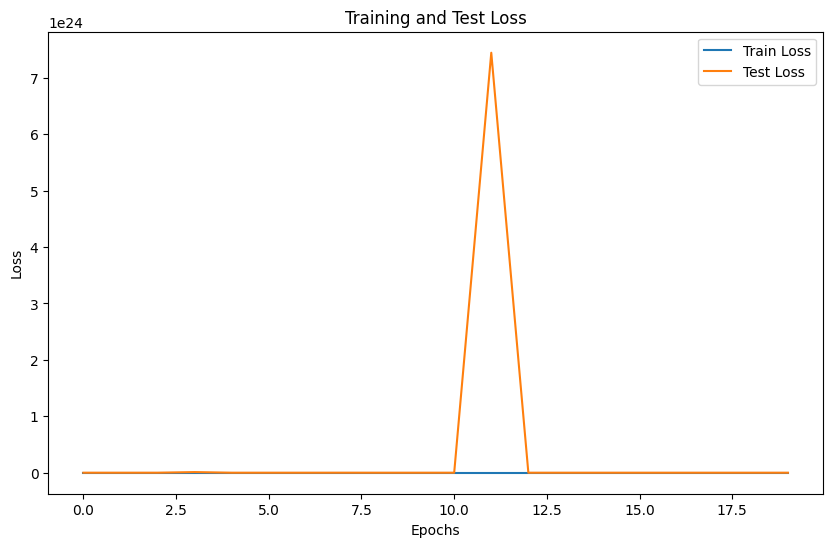

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
train_loss = history.history['loss']
test_loss = history.history['val_loss']
 
# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()